In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

#Statistics
# Statistics
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.special import inv_boxcox
from scipy.stats import boxcox
from scipy.interpolate import interp1d

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from dateutil.parser import parse 
import pickle

# READ CSV AND DESCRIPTION OF SERIES


In [2]:
#MARKET PRICE
market_price = pd.read_csv("data/market-price.csv")

market_price['Timestamp'] = market_price['Timestamp'].str.split(' ').str[0]
market_price["Timestamp"] = pd.to_datetime(market_price["Timestamp"])
market_price = market_price.rename(columns={'market-price': 'Price'})

#Description
print(market_price.head())
print("\nShape is:", market_price.shape)
print("\nSummary of the dataset:")
market_price.describe()
print("\nAre there null values?")
market_price.isna().sum()

   Timestamp  Price
0 2009-01-02    0.0
1 2009-01-05    0.0
2 2009-01-08    0.0
3 2009-01-11    0.0
4 2009-01-14    0.0

Shape is: (1665, 2)

Summary of the dataset:

Are there null values?


Timestamp    0
Price        0
dtype: int64

# VISUALIZATION

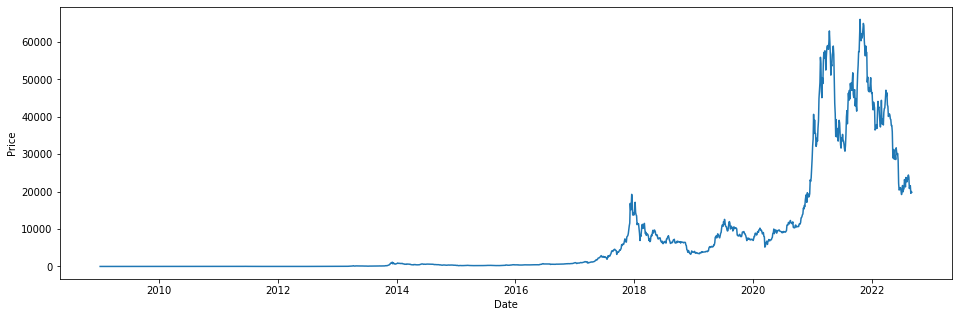

In [3]:
plt.figure(figsize=(16,5))
plt.plot(market_price["Timestamp"], market_price["Price"])
plt.gca().set(xlabel="Date", ylabel="Price")
#scommentare riga giù per visualizzare in scala log
#plt.yscale('log') 
plt.show()

/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


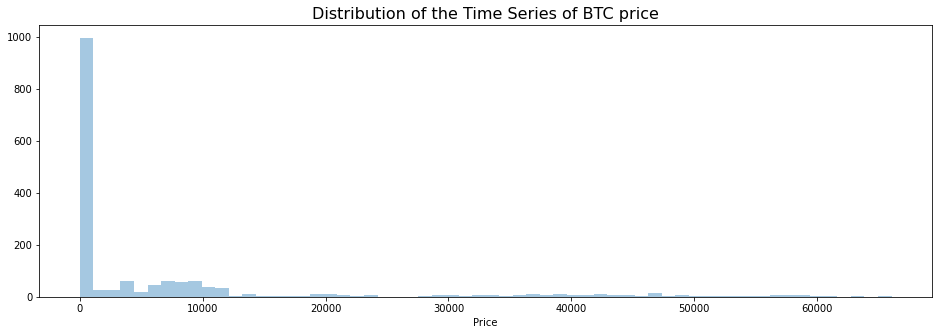

In [4]:
plt.figure(figsize=(16,5))
sns.distplot(market_price["Price"], kde = False, bins = 60)
plt.title('Distribution of the Time Series of BTC price', fontsize=16)
plt.show()